In [14]:
import pandas as pd

In [15]:
df = pd.read_csv('D:/ds/leopard-challenge/train.csv')

In [16]:
test_new = pd.read_csv('D:/ds/leopard-challenge/test.csv')
test_new['Price'] = 1

In [17]:
test_new.shape

(8818, 22)

In [18]:
df.shape

(18373, 22)

C:\Users\ev708\AppData\Local\Temp\ipykernel_14836\2024418801.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True,cmap="coolwarm")


<Axes: >

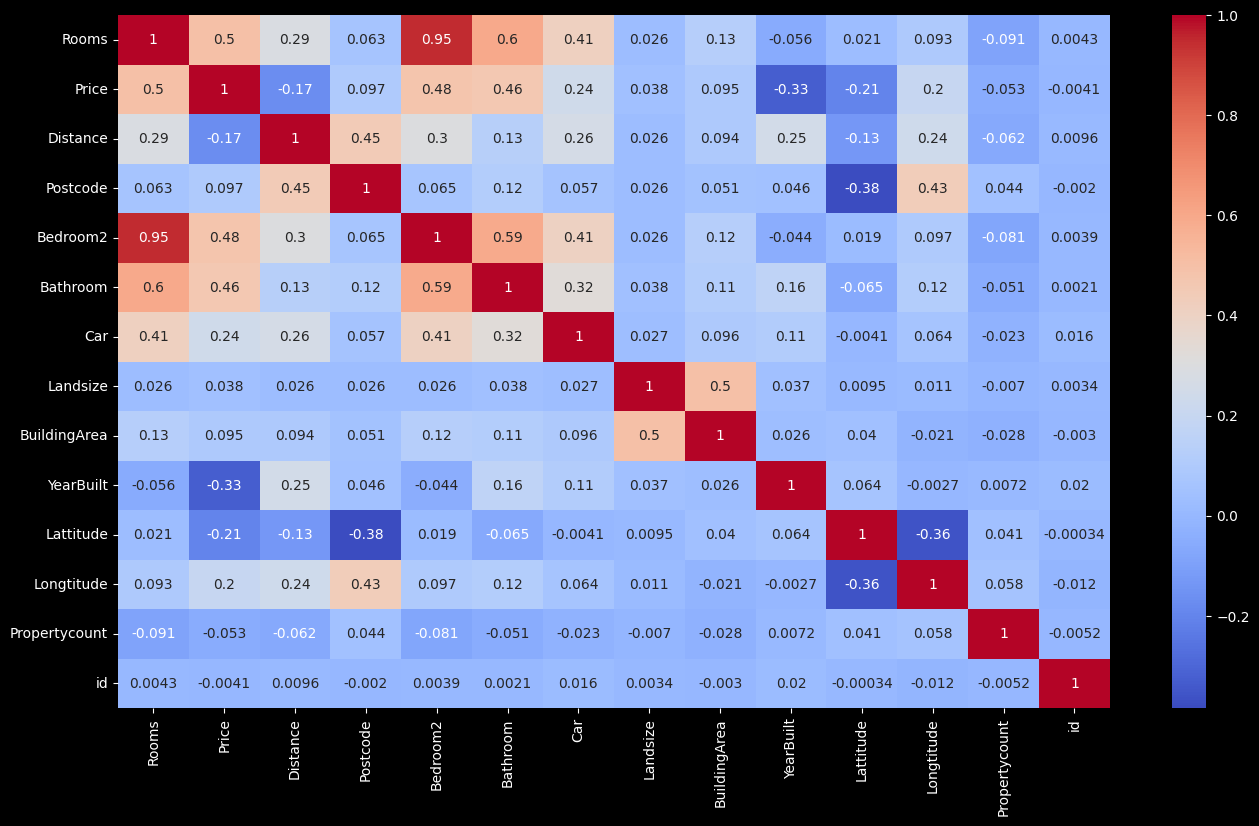

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),annot=True,cmap="coolwarm")

# Выполняем предобработку данных и избавляемся от NaN

In [7]:
df.isna().mean()

Suburb           0.000000
Address          0.000000
Rooms            0.000000
Type             0.000000
Price            0.000000
Method           0.000000
SellerG          0.000000
Date             0.000000
Distance         0.000000
Postcode         0.000000
Bedroom2         0.188755
Bathroom         0.188864
Car              0.194579
Landsize         0.260926
BuildingArea     0.578185
YearBuilt        0.513199
CouncilArea      0.000054
Lattitude        0.181353
Longtitude       0.181353
Regionname       0.000054
Propertycount    0.000054
id               0.000000
dtype: float64

In [8]:
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object' and df[c].dtype.name != 'datetime64[ns]' and c != 'price']

In [9]:
from sklearn.impute import SimpleImputer
import numpy as np
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [10]:
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])
test_new[numerical_columns] = imputer.transform(test_new[numerical_columns])

In [11]:
df['CouncilArea'] = df['CouncilArea'].transform(lambda x: x.fillna('no_info'))
df['Regionname'] = df['Regionname'].transform(lambda x: x.fillna('no_info'))

test_new['CouncilArea'] = test_new['CouncilArea'].transform(lambda x: x.fillna('no_info'))
test_new['Regionname'] = test_new['Regionname'].transform(lambda x: x.fillna('no_info'))

In [12]:
df.isna().mean()

Suburb           0.0
Address          0.0
Rooms            0.0
Type             0.0
Price            0.0
Method           0.0
SellerG          0.0
Date             0.0
Distance         0.0
Postcode         0.0
Bedroom2         0.0
Bathroom         0.0
Car              0.0
Landsize         0.0
BuildingArea     0.0
YearBuilt        0.0
CouncilArea      0.0
Lattitude        0.0
Longtitude       0.0
Regionname       0.0
Propertycount    0.0
id               0.0
dtype: float64

# Начинаем сборку модели машинного обучения

In [13]:
from sklearn.model_selection import train_test_split
train, test =  train_test_split(df,test_size=0.2,random_state=42)

In [170]:
y  = ['Price']
X = list(df.drop(columns = ['Price']).columns)
cat_features = list(df.select_dtypes(include = ['object']).columns)

In [171]:
from catboost import Pool

train_data = Pool(data=train[X], 
                  label=train[y], 
                  cat_features=cat_features)

# Подбор параметров

In [172]:
def objective(trial):
    global train_data

    param = {
        #'task_type':trial.suggest_categorical("task_type", 'CPU'),
        #'devices':trial.suggest_int('devices', 0, 1),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 4000, 200),
        "max_depth": trial.suggest_int("max_depth", 2, 10, 1),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 8),
        "random_strength": trial.suggest_float("random_strength", 0.9, 1.4),
        "learning_rate": trial.suggest_float("eta", 1e-2, 1e-1, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 3, 5),
        "grow_policy": trial.suggest_categorical("grow_policy", ["Lossguide"]),
        #"boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["MAPE"]),
        "loss_function": trial.suggest_categorical("loss_function", ["MAE"]),
        "silent": trial.suggest_categorical("silent", [True]),
        #'logging_level': trial.suggest_categorical('logging_level', ['Silent']),
    }
    
    scores = cv(train_data, param, fold_count=5)

    return scores['test-MAPE-mean'].values[-1]

In [173]:
import optuna
from catboost import cv
#https://habr.com/ru/articles/704432/

In [174]:
# %time
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=5, show_progress_bar = True)

In [1]:
study.best_params

NameError: name 'study' is not defined

In [176]:
best_params1 = {'n_estimators': 3200,
 'max_depth': 3,
 'subsample': 0.5316624539073189,
 'l2_leaf_reg': 6.311327018960008,
 'random_strength': 1.3359931066032458,
 'eta': 0.01380107322092467,
 'min_data_in_leaf': 4,
 'grow_policy': 'Lossguide',
 'eval_metric': 'MAPE',
 'loss_function': 'MAE',
 'silent': True}

In [177]:
from catboost import CatBoostRegressor

In [178]:
model = CatBoostRegressor(**best_params1)

In [179]:
model.fit(train_data)

In [180]:
import joblib

In [181]:
joblib.dump(model, "catboost.pkl", compress=9)

['catboost.pkl']

In [182]:
model_catboost_plk = joblib.load("catboost.pkl")

In [183]:
test['predict'] = model_catboost_plk.predict(test[X])

In [184]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

def error(y_true,y_pred):
  print(mean_absolute_error(y_true,y_pred))
  print(mean_absolute_percentage_error(y_true,y_pred))

In [185]:
error(test['Price'],test['predict'])

177583.79830740506
0.1573610886390779


In [186]:
model.get_feature_importance(prettified=True)

Feature Id  Importances
0          Suburb    20.021170
1            Type    19.925629
2           Rooms    15.003946
3      Regionname    10.073113
4        Distance     8.100435
5     CouncilArea     6.422384
6         SellerG     3.642186
7        Bathroom     3.360139
8    BuildingArea     3.339453
9        Landsize     2.391473
10      YearBuilt     1.960359
11       Postcode     1.861417
12     Longtitude     0.878939
13      Lattitude     0.693551
14       Bedroom2     0.640535
15            Car     0.462804
16         Method     0.416265
17  Propertycount     0.383975
18           Date     0.375222
19             id     0.043449
20        Address     0.003557

# Загружаем датасет для submission

In [191]:
test_new.shape

(8818, 22)

In [217]:
test_new['Price'] = model_catboost_plk.predict(test_new[X])

In [230]:
test_new.head()

Suburb          Address  Rooms Type Method SellerG       Date  \
0    Abbotsford  513/6 Acacia Pl    3.0    u      S  Dingle  7/10/2017   
1    Abbotsford    60 Charles St    3.0    h      S  Jellis  7/10/2017   
2    Abbotsford    38 Studley St    3.0    h      S  Nelson  7/10/2017   
3  Airport West     18 Glenys Av    3.0    h      S   Raine  7/10/2017   
4  Airport West     35 Thomas St    3.0    h      S  Nelson  7/10/2017   

   Distance  Postcode  Bedroom2  ...  Landsize  BuildingArea  YearBuilt  \
0       3.0    3067.0       3.0  ...     440.0         126.0     1970.0   
1       3.0    3067.0       3.0  ...     192.0         109.0     1900.0   
2       3.0    3067.0       3.0  ...     159.0          93.0     1890.0   
3      10.4    3042.0       3.0  ...     536.0         108.0     1980.0   
4      10.4    3042.0       3.0  ...     440.0         130.0     2009.0   

                  CouncilArea  Lattitude Longtitude             Regionname  \
0          Yarra City Council  -37.80360  145.00110  Northern Metropolitan   
1          Yarra City Council  -37.80792  144.99508  Northern Metropolitan   
2          Yarra City Council  -37.80124  144.99459  Northern Metropolitan   
3  Moonee Valley City Council  -37.72285  144.87539   Western Metropolitan   
4  Moonee Valley City Council  -37.71754  144.87704   Western Metropolitan   

   Propertycount       id         Price  
0         4019.0  30130.0  8.877361e+05  
1         4019.0  18311.0  1.399765e+06  
2         4019.0  18934.0  1.283037e+06  
3         3464.0   1824.0  7.740891e+05  
4         3464.0  31339.0  7.637507e+05  

[5 rows x 22 columns]

In [231]:
test_new_id_price = test_new[['id','Price']]

In [232]:
test_new_id_price['id'] = test_new_id_price['id'].astype(int)
test_new_id_price


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


id         Price
0     30130  8.877361e+05
1     18311  1.399765e+06
2     18934  1.283037e+06
3      1824  7.740891e+05
4     31339  7.637507e+05
...     ...           ...
8813  11120  1.231989e+06
8814   3950  6.784068e+05
8815   2209  6.244651e+05
8816  23872  1.034314e+06
8817   8572  7.954555e+05

[8818 rows x 2 columns]

In [233]:
test_new_id_price.to_csv('my_sub_new.csv', index=False)

In [234]:
test_ = pd.read_csv('D:/ds/leopard-challenge/my_sub_new.csv')

In [235]:
test_

id         Price
0     30130  8.877361e+05
1     18311  1.399765e+06
2     18934  1.283037e+06
3      1824  7.740891e+05
4     31339  7.637507e+05
...     ...           ...
8813  11120  1.231989e+06
8814   3950  6.784068e+05
8815   2209  6.244651e+05
8816  23872  1.034314e+06
8817   8572  7.954555e+05

[8818 rows x 2 columns]